In [73]:
import kagglehub
import os
import shutil

move_folder = './data'
dataset_path = kagglehub.dataset_download("fedesoriano/air-quality-data-set")

# Moving files to target folder
if not os.path.exists(move_folder):
    os.makedirs(move_folder)

for file in os.listdir(dataset_path):
    src_path = os.path.join(dataset_path, file)
    dst_path = os.path.join(move_folder, file)
    shutil.move(src_path, dst_path)

print(f"Files moved to: {move_folder}")

Files moved to: ./data


In [74]:
import pandas as pd

# Load the original CSV file
input_file = "./data/AirQuality.csv"  # Replace with your actual CSV file name
output_file = "formatted_output.csv"

# Read the input CSV file
data = pd.read_csv(input_file, delimiter=';')

# Process the columns to match the desired format
formatted_data = pd.DataFrame()

# Format the columns based on the provided image structure
formatted_data["Date (DD/MM/YYYY)"] = data["Date"]
formatted_data["Time (HH.MM.SS)"] = data["Time"]
formatted_data["CO(GT)"] = data["CO(GT)"]
formatted_data["PT08.S1(CO)"] = data["PT08.S1(CO)"]
formatted_data["NMHC(GT)"] = data["NMHC(GT)"]
formatted_data["C6H6(GT)"] = data["C6H6(GT)"]
formatted_data["PT08.S2(NMHC)"] = data["PT08.S2(NMHC)"]
formatted_data["NOx(GT)"] = data["NOx(GT)"]
formatted_data["PT08.S3(NOx)"] = data["PT08.S3(NOx)"]
formatted_data["NO2(GT)"] = data["NO2(GT)"]
formatted_data["PT08.S4(NO2)"] = data["PT08.S4(NO2)"]
formatted_data["PT08.S5(O3)"] = data["PT08.S5(O3)"]
formatted_data["T"] = data["T"]
formatted_data["RH"] = data["RH"]
formatted_data["AH"] = data["AH"]

# Save the formatted data to a new CSV file
formatted_data.to_csv(output_file, index=False)

print(f"Formatted CSV file has been saved as {output_file}")


Formatted CSV file has been saved as formatted_output.csv


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
input_file = "formatted_output.csv"  # Ensure the file is in the same directory
data = pd.read_csv(input_file)

In [76]:
# Preprocessing
# Replace commas with dots and convert numeric columns to float
data = data.replace({',': '.'}, regex=True)

# Convert date and time to a datetime object and set it as the index
data['Datetime'] = pd.to_datetime(data['Date (DD/MM/YYYY)'] + ' ' + data['Time (HH.MM.SS)'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Drop rows with invalid datetime parsing
data = data.dropna(subset=['Datetime'])
data.set_index('Datetime', inplace=True)

# Drop unnecessary columns and handle missing values
data = data.drop(['Date (DD/MM/YYYY)', 'Time (HH.MM.SS)'], axis=1)
data = data.replace([-200], np.nan)  # Replace placeholder values with NaN
data = data.fillna(method='ffill')  # Fill missing values using forward fill
data = data.fillna(method='bfill')  # Backfill as a fallback for remaining NaN values

# Convert numeric columns to float
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')


# Scale features using MinMaxScaler for better performance
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

# Features and target variable
features = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)']  # Example features for demonstration
target = 'CO(GT)'

# EDA: Dataset Summary
print("\nDataset Summary:")
print(data.describe())
print("\nMissing Values:")
print(data.isnull().sum())


Dataset Summary:
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1102.730362   270.496740     1.865683     942.548253   
std      77.657170   219.588101    73.306853    41.380206     269.581368   
min    -200.000000   647.000000     7.000000  -200.000000     383.000000   
25%       0.600000   938.000000   275.000000     4.000000     733.000000   
50%       1.500000  1062.000000   275.000000     7.900000     911.000000   
75%       2.600000  1237.000000   275.000000    13.600000    1117.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    240.731217    832.742225   109.414877   1453.014535  1030.511916   
std     206.618453    255.709423    47.221662    347.434084   410.916

C:\Users\boobb\AppData\Local\Temp\ipykernel_2704\3969689962.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Fill missing values using forward fill
C:\Users\boobb\AppData\Local\Temp\ipykernel_2704\3969689962.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')  # Backfill as a fallback for remaining NaN values


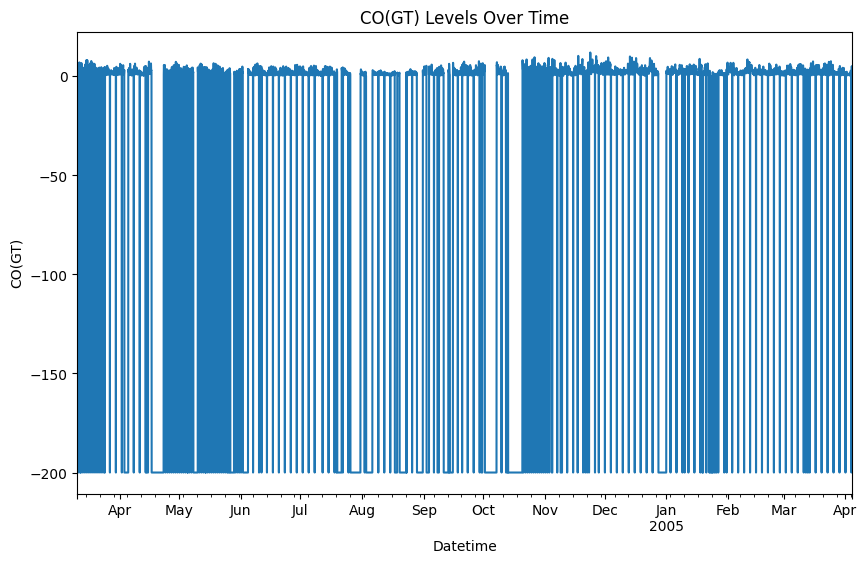

<Figure size 1000x600 with 0 Axes>

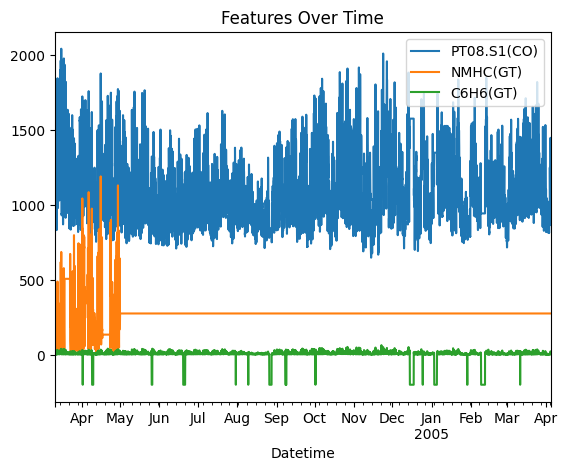

In [61]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
data[target].plot(title="CO(GT) Levels Over Time")
plt.xlabel("Datetime")
plt.ylabel("CO(GT)")
plt.show()

plt.figure(figsize=(10, 6))
data[features].plot(title="Features Over Time")
plt.xlabel("Datetime")
plt.legend(features)
plt.show()

In [62]:
# Task 1: Predicting future air quality levels (Random Forest)
# Prepare data for machine learning
X = data_scaled[features]
y = data_scaled[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [63]:
# Random Forest Model Summary
print("\nRandom Forest Model Summary:")
print(f"Number of Estimators: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"Feature Importances: {rf_model.feature_importances_}")


Random Forest Model Summary:
Number of Estimators: 200
Max Depth: 10
Feature Importances: [0.30116291 0.49252941 0.20630767]


In [64]:
# Make predictions
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f"Random Forest Mean Squared Error: {rf_mse}")
print(f"Random Forest Mean Absolute Error: {rf_mae}")

Random Forest Mean Squared Error: 0.11529563840731313
Random Forest Mean Absolute Error: 0.24053292088793005


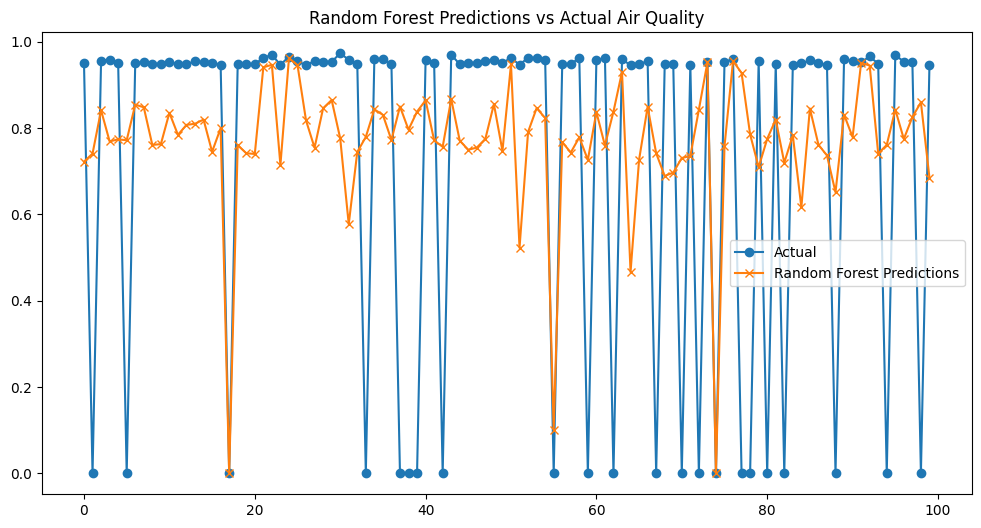

In [65]:
# Visualization of Random Forest predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100].values, label="Actual", marker='o')
plt.plot(rf_predictions[:100], label="Random Forest Predictions", marker='x')
plt.title("Random Forest Predictions vs Actual Air Quality")
plt.legend()
plt.show()

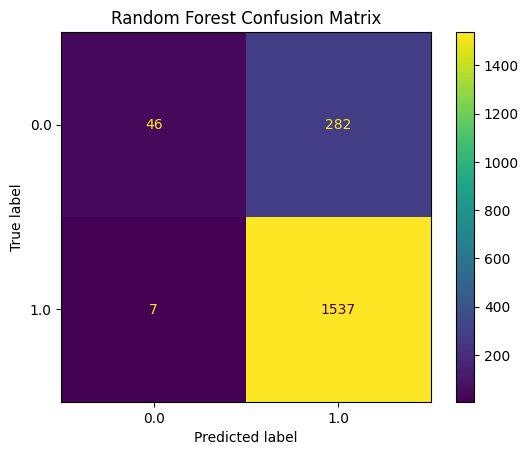

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.14      0.24       328
         1.0       0.84      1.00      0.91      1544

    accuracy                           0.85      1872
   macro avg       0.86      0.57      0.58      1872
weighted avg       0.85      0.85      0.80      1872



In [66]:

# Confusion Matrix and Classification Report for Random Forest
rf_predictions_class = np.round(rf_predictions)
y_test_class = np.round(y_test.values)
ConfusionMatrixDisplay.from_predictions(y_test_class, rf_predictions_class)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test_class, rf_predictions_class))

In [67]:
# Task 2: Predicting air quality using LSTM
# Prepare data for LSTM
lstm_data = data_scaled[[target] + features]
lstm_data = lstm_data.values

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 1:])  # Features
        y.append(data[i+sequence_length, 0])  # Target
    return np.array(X), np.array(y)

sequence_length = 24  # Use past 24 hours to predict the next hour
X_lstm, y_lstm = create_sequences(lstm_data, sequence_length)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

d:\software\anaconda3\envs\gpu-process-task\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# LSTM Model Summary
print("\nLSTM Model Summary:")
lstm_model.summary()


LSTM Model Summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# Evaluate the model
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test_lstm, lstm_predictions)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_predictions)
print(f"LSTM Mean Squared Error: {lstm_mse}")
print(f"LSTM Mean Absolute Error: {lstm_mae}")

Epoch 1/50


234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2418 - val_loss: 0.1300
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1513 - val_loss: 0.1271
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1407 - val_loss: 0.1254
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1480 - val_loss: 0.1217
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1437 - val_loss: 0.1253
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1408 - val_loss: 0.1219
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1404 - val_loss: 0.1209
Epoch 8/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1372 - val_loss: 0.1209
Epoch 9/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1399 - val_loss: 0.1210
Epoch 10/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1379 - val_loss: 0.1211
Epoch 11/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1360 - val_loss: 0.1248
Epoch 12/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

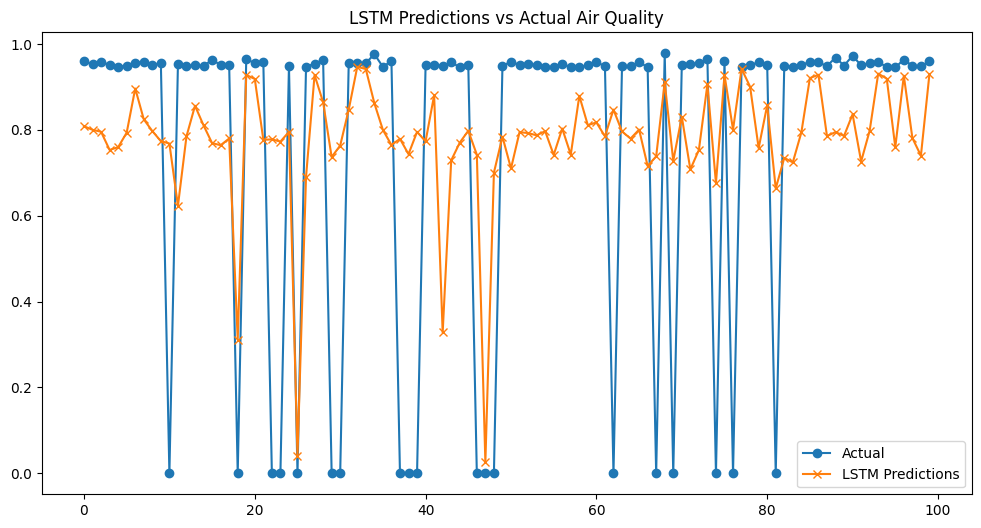

In [70]:
# Visualization of LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm[:100], label="Actual", marker='o')
plt.plot(lstm_predictions[:100], label="LSTM Predictions", marker='x')
plt.title("LSTM Predictions vs Actual Air Quality")
plt.legend()
plt.show()

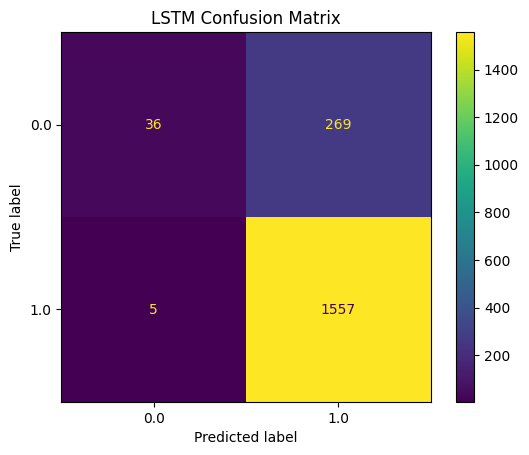

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.12      0.21       305
         1.0       0.85      1.00      0.92      1562

    accuracy                           0.85      1867
   macro avg       0.87      0.56      0.56      1867
weighted avg       0.86      0.85      0.80      1867



In [71]:

# Confusion Matrix and Classification Report for LSTM
lstm_predictions_class = np.round(lstm_predictions.flatten())
y_test_lstm_class = np.round(y_test_lstm)
ConfusionMatrixDisplay.from_predictions(y_test_lstm_class, lstm_predictions_class)
plt.title("LSTM Confusion Matrix")
plt.show()

print("LSTM Classification Report:")
print(classification_report(y_test_lstm_class, lstm_predictions_class))
